In [7]:
from utilities import *
from astropy.io import fits
import math 
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import visualization
import os
import pdb
from scipy.optimize import curve_fit as cf
from astropy.modeling import powerlaws, fitting
from operator import add,sub,truediv
from matplotlib import gridspec
from astropy.table import QTable, vstack, hstack
import radio_beam
import sys
import regions
from astropy.wcs import WCS

plt.rcParams['figure.dpi'] = 300

source='DSVI'
fnum=fields[source]
central_pix=pixdict[source]
c2h5oh_sourcelocs={'DSi':'/oct2024_1_removesDS2exclusions/','DSii':'/oct2024_1_removeproblemlines/',
                   'DSiii':'/dec2024_3_try-close-to-FWZI/','DSiv':'/nov2024_1_firstrun_removesDS2exclusions/',
                   'DSVI':'/nov2024_1_removesDS2exclusions/'}
ch3oh_datadir=f'/blue/adamginsburg/d.jeff/imaging_results/SgrB2DS-CH3OH/sep2023revolution/'#SgrB2S lives in the pacman_sep2023revolution folder, if we ever get to it
c2h5oh_datadir=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/C2H5OH/{source}'+c2h5oh_sourcelocs[source]

path_c2h5oh_trot=c2h5oh_datadir+'texmap_3sigma_allspw_withnans_weighted.fits'
path_error_c2h5oh_trot=c2h5oh_datadir+'texmap_error_allspw_withnans_weighted.fits'

path_c2h5oh_trot=c2h5oh_datadir+'texmap_3sigma_allspw_withnans_weighted.fits'
path_error_c2h5oh_trot=c2h5oh_datadir+'texmap_error_allspw_withnans_weighted.fits'

path_nch3oh=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/CH3OH/{source}/{ch3oh_sourcedict[source]}'+'bootstrap_ntot_intstd_boostrap1000_nonegativeslope.fits'
path_ratio=c2h5oh_datadir+'nc2h5oh_nch3oh_ratio_3sigma_lessthan1.fits'
path_error_ratio=c2h5oh_datadir+'nc2h5oh_nch3oh_ratio_error.fits'

hdu_c2h5oh_trot=fits.open(path_c2h5oh_trot)
data_c2h5oh_trot=hdu_c2h5oh_trot[0].data
error_c2h5oh_trot=fits.getdata(path_error_c2h5oh_trot)
cellsize=(np.abs(hdu_c2h5oh_trot[0].header['CDELT1']*u.deg)).to('arcsec')
pixtophysicalsize=(np.tan(cellsize)*jeff2024_dGC).to('AU')

data_ch3oh_radialtemperatures=np.genfromtxt(ch3oh_datadir+f'{source}_tex.txt')
error_ch3oh_radialtemperatures=np.genfromtxt(ch3oh_datadir+f'{source}_errtex.txt')

data_nch3oh=np.squeeze(fits.getdata(path_nch3oh))
data_ethanol_methanol_ratio=np.squeeze(fits.getdata(path_ratio))
error_ethanol_methanol_ratio=np.squeeze(fits.getdata(path_error_ratio))

rdict={'SgrB2S':9500*u.AU,'DSi':8000*u.AU,'DSii':5500*u.AU,'DSiii':6000*u.AU,'DSiv':6000*u.AU,'DSv':7000*u.AU,
       'DSVI':10000*u.AU,'DSVII':6000*u.AU,'DSVIII':5400*u.AU,'DSIX':8000*u.AU}#1-6400,4-8500,5-4000,7-6600,S-12000
if source not in rdict.keys():
    r_phys=10000*u.AU
else:
    r_phys=rdict[source]#r*pixtophysicalsize.to('pc')
r=math.ceil((r_phys/pixtophysicalsize).to(''))

yy,xx=np.indices(data_c2h5oh_trot.shape)
rr=((xx-central_pix[1])**2+(yy-central_pix[0])**2)**0.5
mask=rr<r
radialdistance=(rr[mask]*pixtophysicalsize).value

In [8]:
c2h5oh_trots=hstack([radialdistance,data_c2h5oh_trot[mask]],table_names=['Distance','Trot'])
error_c2h5oh_trots=hstack([radialdistance,error_c2h5oh_trot[mask]],table_names=['Distance','Trot Error'])
ordered_c2h5oh_trots=c2h5oh_trots[c2h5oh_trots.argsort()]
ordered_error_c2h5oh_trots=error_c2h5oh_trots[error_c2h5oh_trots.argsort()]

nch3oh_table=hstack([radialdistance,data_nch3oh[mask]],table_names=['Distance','N(CH3OH)'])
ratio_table=hstack([radialdistance,data_ethanol_methanol_ratio[mask],error_ethanol_methanol_ratio[mask]],table_names=['Distance','Ethanol_Methanol_Ratio','Error_Ethanol_Methanol_Ratio'])

ordered_radialdistances=list(set(ordered_c2h5oh_trots['col0_Distance']))
ordered_radialdistances.sort()

upperfillcutoff={'DSi':400,'DSii':310,'DSiv':600,'DSVI':450}#K
trotcutoff={'DSi':350,'DSii':300,'DSiv':500,'DSVI':350}

In [9]:
radial_average_trots=QTable()#names=['Distance','Trot'],units=['AU','K'])
ch3oh_trot_table=QTable([radialdistance,data_ch3oh_radialtemperatures,error_ch3oh_radialtemperatures],names=['Distance','Trot','Trot Error'])
radial_average_nch3oh=QTable()
radial_average_ratio=QTable()
for radial_bin in ordered_radialdistances:
    trots_in_radial_bin=ordered_c2h5oh_trots[np.where(ordered_c2h5oh_trots['col0_Distance']==radial_bin)[0]]
    error_trots_in_radial_bin=ordered_error_c2h5oh_trots[np.where(ordered_error_c2h5oh_trots['col0_Distance']==radial_bin)[0]]
    average_trot_in_bin=np.nanmean(trots_in_radial_bin['col0_Trot'])
    average_error_trot_in_bin=np.nanmean(error_trots_in_radial_bin['col0_Trot Error'])
    if radial_bin == 0:
        trotupperfill=average_trot_in_bin+average_error_trot_in_bin
        trotlowerfill=average_trot_in_bin-average_error_trot_in_bin
    else:
        trotupperfill=np.nanmax(trots_in_radial_bin['col0_Trot'])
        trotlowerfill=np.nanmin(trots_in_radial_bin['col0_Trot'])
    if average_trot_in_bin >= 3*average_error_trot_in_bin and average_trot_in_bin <= trotcutoff[source] and trotupperfill < upperfillcutoff[source]:
        table_to_append=QTable([{'Distance':radial_bin,'Trot':average_trot_in_bin,'Upper Trot':trotupperfill,'Lower Trot':trotlowerfill}])#,names=['Distance','Trot'],units=['AU','K'])
        radial_average_trots=vstack([radial_average_trots,table_to_append])

    ch3oh_in_radial_bin=ch3oh_trot_table[np.where(ch3oh_trot_table['Distance']==radial_bin)[0]]
    average_ch3oh_trot_in_bin=np.nanmean(ch3oh_in_radial_bin['Trot'])
    average_error_ch3oh_trot_in_bin=np.nanmean(ch3oh_in_radial_bin['Trot Error'])
    if radial_bin == 0:
        ch3oh_trotupperfill=average_ch3oh_trot_in_bin+average_error_ch3oh_trot_in_bin
        ch3oh_trotlowerfill=average_ch3oh_trot_in_bin-average_error_ch3oh_trot_in_bin
    else:
        ch3oh_trotupperfill=np.nanmax(ch3oh_in_radial_bin['Trot'])
        ch3oh_trotlowerfill=np.nanmin(ch3oh_in_radial_bin['Trot'])
    ch3oh_table_to_append=QTable([{'Distance':radial_bin,'Trot':average_ch3oh_trot_in_bin,'Upper Trot':ch3oh_trotupperfill,
                                   'Lower Trot':ch3oh_trotlowerfill}])
    radial_average_nch3oh=vstack([radial_average_nch3oh,ch3oh_table_to_append])

    nch3oh_in_radial_bin=nch3oh_table[np.where(nch3oh_table['col0_Distance']==radial_bin)[0]]
    average_nch3oh_in_bin=np.nanmean(nch3oh_in_radial_bin['col0_N(CH3OH)'])
    '''
    average_error_ch3oh_trot_in_bin=np.nanmean(ch3oh_in_radial_bin['Trot Error'])
    if radial_bin == 0:
        nch3oh_trotupperfill=average_nch3oh_in_bin+average_error_ch3oh_trot_in_bin
        nch3oh_trotlowerfill=average_nch3oh_in_bin-average_error_ch3oh_trot_in_bin
    else:
        ch3oh_trotupperfill=np.nanmax(ch3oh_in_radial_bin['Trot'])
        ch3oh_trotlowerfill=np.nanmin(ch3oh_in_radial_bin['Trot'])
    '''
    nch3oh_table_to_append=QTable([{'Distance':radial_bin,'N(CH3OH)':average_nch3oh_in_bin,}])#'Upper Trot':ch3oh_trotupperfill,'Lower Trot':ch3oh_trotlowerfill}])
    radial_average_nch3oh=vstack([radial_average_nch3oh,nch3oh_table_to_append])

    ratio_in_radial_bin=ratio_table[np.where(ratio_table['col0_Distance']==radial_bin)[0]]
    average_ratio_in_bin=np.nanmean(ratio_in_radial_bin['col0_Ethanol_Methanol_Ratio'])
    average_ratio_error_in_bin=np.nanmean(ratio_in_radial_bin['col0_Error_Ethanol_Methanol_Ratio'])
    '''
    average_error_ch3oh_trot_in_bin=np.nanmean(ch3oh_in_radial_bin['Trot Error'])
    if radial_bin == 0:
        nch3oh_trotupperfill=average_nch3oh_in_bin+average_error_ch3oh_trot_in_bin
        nch3oh_trotlowerfill=average_nch3oh_in_bin-average_error_ch3oh_trot_in_bin
    else:
        ch3oh_trotupperfill=np.nanmax(ch3oh_in_radial_bin['Trot'])
        ch3oh_trotlowerfill=np.nanmin(ch3oh_in_radial_bin['Trot'])
    '''
    if average_ratio_in_bin >= 3*average_ratio_error_in_bin:
        ratio_table_to_append=QTable([{'Distance':radial_bin,'Ethanol_Methanol_Ratio':average_ratio_in_bin,
                                   'Error_Ethanol_Methanol_Ratio':average_ratio_error_in_bin}])#'Upper Trot':ch3oh_trotupperfill,'Lower Trot':ch3oh_trotlowerfill}])
        radial_average_ratio=vstack([radial_average_ratio,ratio_table_to_append])
    #pdb.set_trace()
    #print(radial_bin)
    #pdb.set_trace()
print(radial_average_ratio)

Mean of empty slice
All-NaN axis encountered
All-NaN axis encountered
Mean of empty slice
Mean of empty slice
Mean of empty slice
All-NaN axis encountered
All-NaN axis encountered
Mean of empty slice
All-NaN axis encountered
All-NaN axis encountered
Mean of empty slice
All-NaN axis encountered
All-NaN axis encountered
Mean of empty slice
All-NaN axis encountered
All-NaN axis encountered
Mean of empty slice
All-NaN axis encountered
All-NaN axis encountered
Mean of empty slice
All-NaN axis encountered
All-NaN axis encountered
Mean of empty slice
Mean of empty slice
Mean of empty slice
All-NaN axis encountered
All-NaN axis encountered
Mean of empty slice
All-NaN axis encountered
All-NaN axis encountered
Mean of empty slice
All-NaN axis encountered
All-NaN axis encountered
Mean of empty slice
Mean of empty slice
Mean of empty slice
All-NaN axis encountered
All-NaN axis encountered
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of empty slice
Mean of em

     Distance      Ethanol_Methanol_Ratio Error_Ethanol_Methanol_Ratio
------------------ ---------------------- ----------------------------
               0.0     0.7242804877084897          0.13888304840093108
 417.0000000000415     0.6156391255717105          0.11987429070813962
 589.7270555096394     0.6891044474641305          0.12689786418121146
  834.000000000083     0.6271286195850841          0.12337462166948453
 932.4403466175052     0.6030377234956021            0.124787935854813
1179.4541110192788     0.5588027955106827          0.11591730955644697
1251.0000000001246     0.6151280809814323           0.1058696233802141
1318.6697842903454     0.5269311803068348          0.10622928731608686
 1503.514881868633     0.5277108476428266          0.10643135303857547
 1668.000000000166     0.5124432784248892          0.12576149862874114
               ...                    ...                          ...
  9435.63288815423     0.5833377804492956           0.1142526226899448
  9518

In [1]:
plt.figure()
#plt.scatter(radial_average_nch3oh['Distance'],radial_average_nch3oh['N(CH3OH)'],label=r'C$_2$H$_5$OH')
#plt.fill_between(radial_average_trots['Distance'],radial_average_trots['Upper Trot'],radial_average_trots['Lower Trot'],alpha=0.2,color='blue')

#plt.scatter(radial_average_nch3oh['Distance'],radial_average_nch3oh['N(C2H5OH)'],label=r'C$_2$H$_5$OH')
#plt.fill_between(radial_average_ch3oh['Distance'],radial_average_ch3oh['Upper Trot'],radial_average_ch3oh['Lower Trot'],alpha=0.2,color='orange')

plt.errorbar(radial_average_ratio['Distance'],radial_average_ratio['Ethanol_Methanol_Ratio'],
             yerr=radial_average_ratio['Error_Ethanol_Methanol_Ratio'],fmt='o')
plt.xlabel('$r$ (AU)',fontsize=14)
plt.ylabel(r'N(C$_2$H$_5$OH)/N(CH$_3$OH)',fontsize=14)
plt.legend()

savefigpath=f'../plots/RadialAbundanceRatioProfiles/{source}/radial_abundanceratio_profile.png'
if not os.path.exists(f'../plots/RadialAbundanceRatioProfiles/{source}/'):
    os.makedirs(f'../plots/RadialAbundanceRatioProfiles/{source}/')
#plt.savefig(savefigpath)

plt.show()

NameError: name 'plt' is not defined

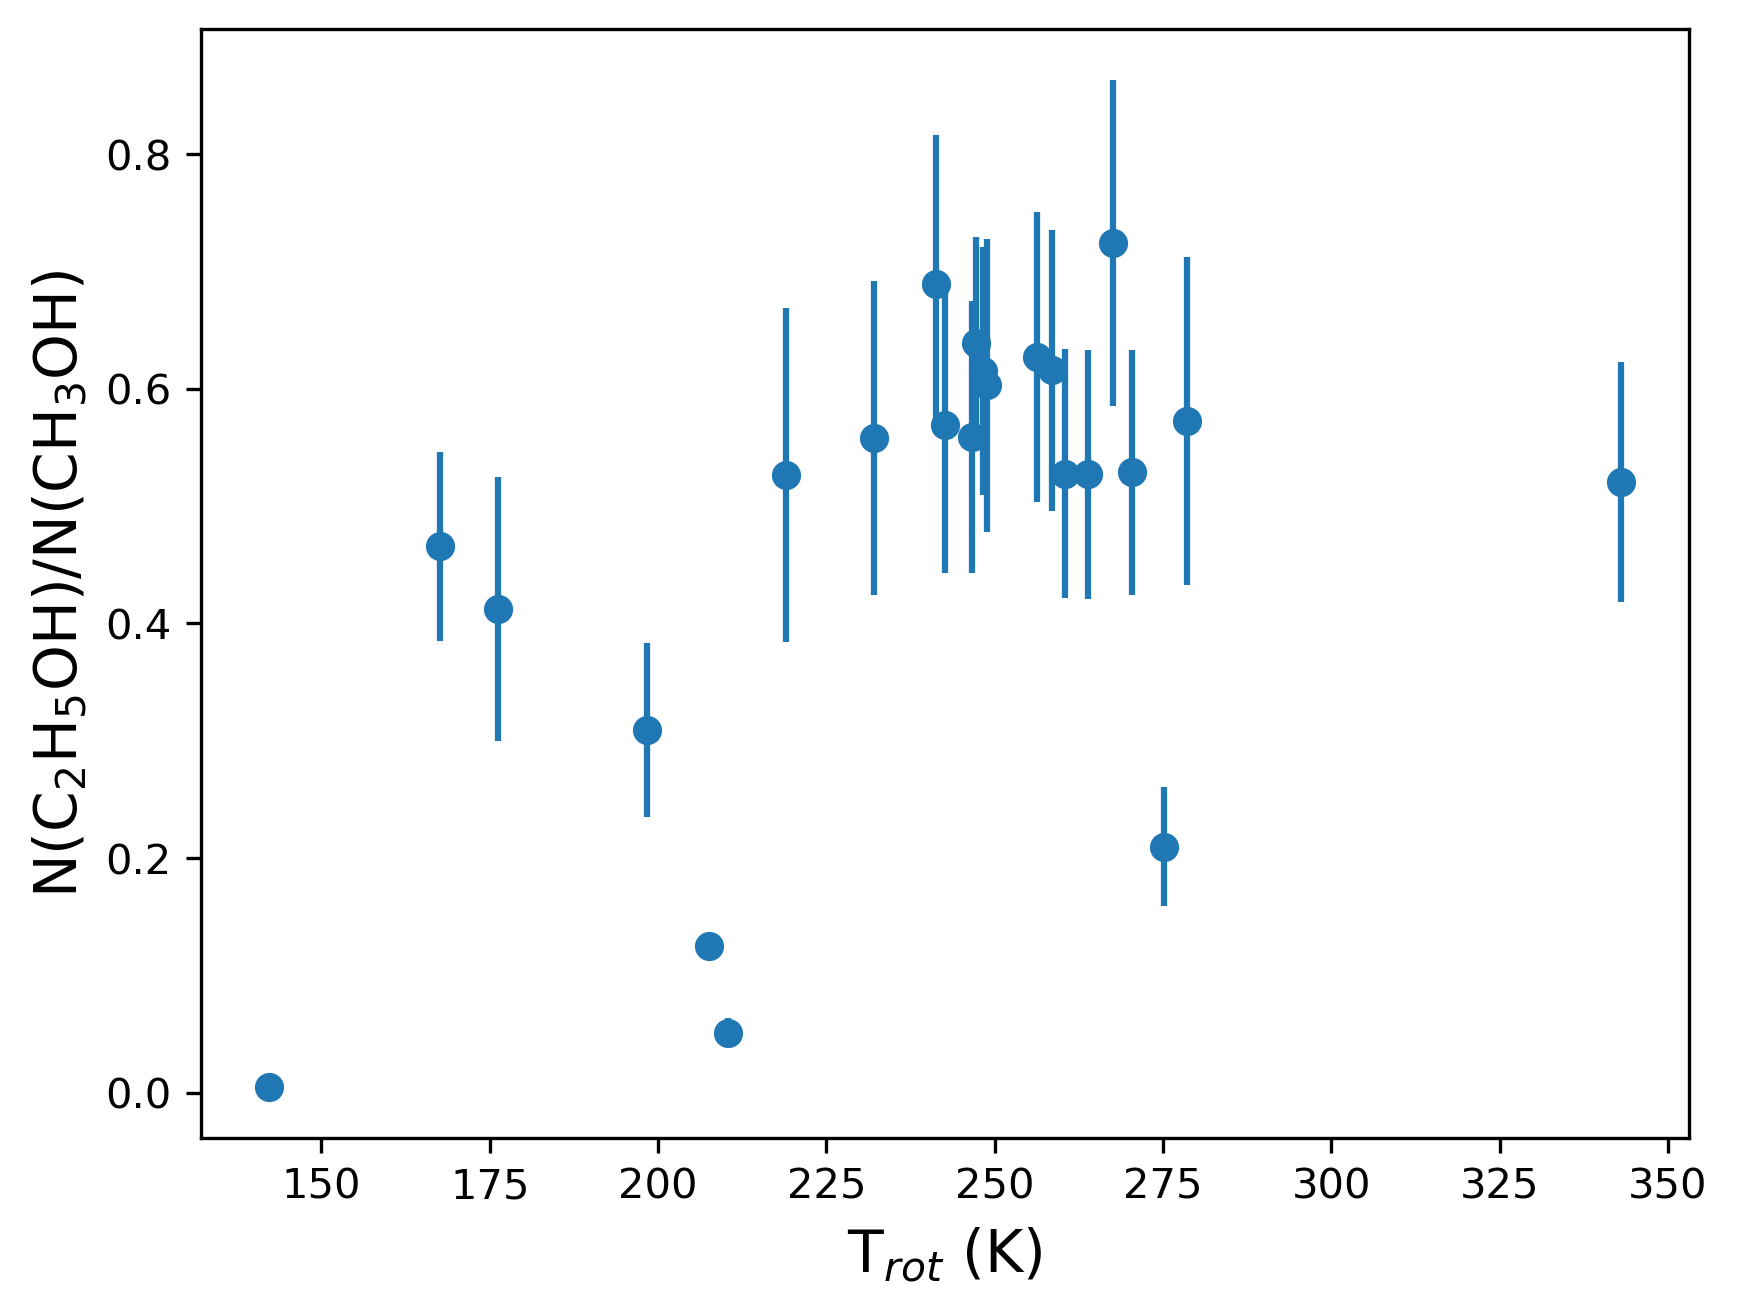

In [51]:
usable_distances=np.intersect1d(np.array(radial_average_ratio['Distance'].data), np.array(radial_average_trots['Distance'].data),
                                               return_indices=True)
usable_ratios=radial_average_ratio[usable_distances[1]]

usable_trots=radial_average_trots[usable_distances[2]]
plt.figure()
plt.errorbar(usable_trots['Trot'],usable_ratios['Ethanol_Methanol_Ratio'],yerr=usable_ratios['Error_Ethanol_Methanol_Ratio'],fmt='o')
plt.ylabel(r'N(C$_2$H$_5$OH)/N(CH$_3$OH)',fontsize=14)
plt.xlabel('T$_{rot}$ (K)',fontsize=14)

savefigpath=f'../plots/AbundanceRatiovsTemperature/{source}/abundanceratio_vs_temperature.png'
if not os.path.exists(f'../plots/AbundanceRatiovsTemperature/{source}/'):
    os.makedirs(f'../plots/AbundanceRatiovsTemperature/{source}/')
plt.savefig(savefigpath)
plt.show()

In [32]:
usable_ratios

Distance,Ethanol_Methanol_Ratio,Error_Ethanol_Methanol_Ratio
float64,float64,float64
0.0,0.13422813633356234,0.02192535572839067
417.0000000000415,0.14236379253144696,0.021420960728491277
589.7270555096394,0.14569800154688706,0.022140216339415923
834.000000000083,0.14632902048832197,0.023602999036923422
932.4403466175052,0.14775882543059843,0.02549100364724354
1179.4541110192788,0.15426801447132893,0.027054581476365226
1251.0000000001246,0.15056079472437103,0.030247705318662037
1318.6697842903454,0.1510700413286103,0.02739698772006735
1503.514881868633,0.15567649213420665,0.02483128016390175


In [107]:
usable_ratios

Distance,Ethanol_Methanol_Ratio,Error_Ethanol_Methanol_Ratio
float64,float64,float64
0.0,0.7242804877084897,0.13888304840093108
417.0000000000415,0.6156391255717105,0.11987429070813962
589.7270555096394,0.6891044474641305,0.12689786418121146
834.000000000083,0.6271286195850841,0.12337462166948453
932.4403466175052,0.6030377234956021,0.124787935854813
1179.4541110192788,0.5588027955106827,0.11591730955644697
1251.0000000001246,0.6151280809814323,0.1058696233802141
1318.6697842903454,0.5269311803068348,0.10622928731608686
1503.514881868633,0.5277108476428266,0.10643135303857547


In [17]:
run bootstrap_makeradialtexdistr.py

Source: DSii
Figpath /blue/adamginsburg/d.jeff/repos/CH3OHTemps/figures/DSii//sep2023-2widerrefslab/ already exists.
Data directory /blue/adamginsburg/d.jeff/imaging_results/SgrB2DS-CH3OH/pacman_sep2023revolution/ already exists.
417.0000000000415 AU
Center p: 211.17109287808958 K
physical radius: 5500.0 AU
[5808.13791159 5671.81320214 5563.47391474 5484.77866463 5437.01480594
 5421.         5437.01480594 5484.77866463 5563.47391474 5671.81320214
 5808.13791159 5793.1491436  5594.64207971 5421.         5274.67913716
 5158.00513765 5073.02395027 5021.34493936 5004.         5021.34493936
 5073.02395027 5158.00513765 5274.67913716 5421.         5594.64207971
 5793.1491436  5671.81320214 5437.01480594 5224.99502392 5038.63017099
 4880.85986277 4754.53152266 4662.20173309 4605.91554417 4587.
 4605.91554417 4662.20173309 4754.53152266 4880.85986277 5038.63017099
 5224.99502392 5437.01480594 5671.81320214 5610.16122763 5340.20561402
 5090.13369176 4863.0138803  4662.20173309 4491.22744915 435

divide by zero encountered in divide


In [18]:
radialdistance == centrtopix

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,